# Deep Learning Term Project for ECG (DIL700)

# Iteration 5

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
# # Original data

train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)

# Synthetic data

# train_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_train.csv')
# train_df = train_df.iloc[:, :-1]
# train_df.rename(columns={'class': 187}, inplace=True)
# test_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_test.csv')
# test_df = test_df.iloc[:, :-1]
# test_df.rename(columns={'class': 187}, inplace=True)

# # Put together the training and testing
# full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [3]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df = train_df[train_df[187] != '3.0']
test_df = test_df[test_df[187] != '3.0']
full_df = full_df[full_df[187] != '3.0']

train_df = train_df[train_df[187] != 'class']
test_df = test_df[test_df[187] != 'class']
full_df = full_df[full_df[187] != 'class']

train_df.loc[train_df[187] == 4, 187] = 3.0
test_df.loc[test_df[187] == 4, 187] = 3.0
full_df.loc[full_df[187] == 4, 187] = 3.0

train_df.loc[train_df[187] == '4.0', 187] = 3.0
test_df.loc[test_df[187] == '4.0', 187] = 3.0
full_df.loc[full_df[187] == '4.0', 187] = 3.0

train_df.loc[train_df[187] == '0.0', 187] = 0.0
train_df.loc[train_df[187] == '1.0', 187] = 1.0
train_df.loc[train_df[187] == '2.0', 187] = 2.0
train_df.loc[train_df[187] == '3.0', 187] = 3.0

In [4]:
print(train_df[187].unique())

[0. 1. 2. 3.]


In [5]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Paced']
labels_short =  ["N","S","V","Q"]

In [6]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
print(labels[3],':', len(train_df[train_df[187]==3]))

Number of samples in data:
Normal : 72471
Artial Premature : 2223
Premature ventricular contraction : 5788
Paced : 6431


In [7]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
print(labels[3],':', len(test_df[test_df[187]==3]))

Number of samples in data:
Normal : 18118
Artial Premature : 556
Premature ventricular contraction : 1448
Paced : 1608


## Preparation

In [8]:
X = full_df.iloc[:, :-1]
y = full_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

In [9]:
# Read csv file into df
df_generated = pd.read_csv('./Dataset_mitbih/Synthetic/generated_samples.csv', header=None)
df_generated = df_generated[df_generated[187] != 187]
df_generated

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
1,1.009011,0.930403,0.256874,0.021120,0.104582,0.154957,0.165496,0.187093,0.255228,0.236050,...,0.006392,0.007372,0.010653,-0.007909,-0.008369,-0.003027,-0.000643,0.002076,0.007087,1
2,0.992405,0.844392,0.170871,0.033316,0.127464,0.136837,0.115636,0.143430,0.221440,0.179224,...,-0.006656,0.000922,0.006377,-0.007758,-0.001063,0.004205,-0.008037,-0.002333,0.011214,1
3,0.954437,0.724671,0.086985,0.078725,0.150889,0.125484,0.110880,0.233273,0.216218,0.162652,...,-0.006683,0.000771,0.010062,-0.010105,0.000045,0.004492,-0.008811,-0.001116,-0.001470,1
4,1.002078,0.903607,0.224465,0.017585,0.080828,0.129751,0.119787,0.151140,0.213260,0.207953,...,-0.004680,0.009514,0.005092,-0.007303,0.000489,0.003619,-0.007154,0.002690,0.006779,1
5,0.920391,0.776423,0.153844,0.030358,0.134456,0.113957,0.099500,0.208505,0.226204,0.208381,...,0.000944,0.003670,-0.001820,-0.001581,-0.016485,-0.008362,0.011371,0.003548,0.023679,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,1.012416,0.851584,0.192768,-0.001881,0.078493,0.129601,0.098687,0.157921,0.212718,0.186132,...,0.000615,0.009250,0.003858,0.000478,0.006906,0.002333,-0.004876,0.007270,0.010998,1
3997,1.007963,0.914214,0.156936,0.001128,0.136839,0.138952,0.090503,0.088809,0.188813,0.156685,...,-0.009490,0.001445,-0.000374,-0.006767,0.007249,-0.002162,-0.019764,0.002554,-0.012706,1
3998,0.924055,0.873919,0.296716,0.018699,0.052322,0.099032,0.121698,0.141230,0.170992,0.166763,...,0.007698,0.005152,0.006106,0.002695,-0.000260,0.001057,-0.001055,-0.008568,0.003436,1
3999,0.973537,0.922856,0.294672,0.038046,0.104563,0.173336,0.159545,0.201123,0.257886,0.260971,...,-0.009271,0.002978,-0.005089,-0.006528,0.002036,0.004128,-0.005783,0.006292,0.002767,1


In [10]:
X_generated = df_generated.iloc[:, :-1]
y_generated = df_generated.iloc[:, -1]

In [11]:
# Add to dfs together
X_train = pd.concat([X_train, X_generated], ignore_index=True)
y_train = pd.concat([y_train, y_generated], ignore_index=True)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})


In [12]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.886935,0.439698,0.213568,0.266332,0.261307,0.238693,0.241206,0.228643,0.233668,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.955654,0.893570,0.811530,0.735033,0.615299,0.478936,0.327051,0.213969,0.127494,0.110865,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.819444,0.620370,0.393519,0.324074,0.280093,0.212963,0.226852,0.247685,0.268519,0.263889,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.782895,0.648026,0.595395,0.595395,0.559211,0.532895,0.486842,0.437500,0.325658,0.217105,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.000000,0.496183,0.515267,0.530534,0.541985,0.538168,0.545802,0.480916,0.370229,0.248092,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73526,1.012416,0.851584,0.192768,-0.001881,0.078493,0.129601,0.098687,0.157921,0.212718,0.186132,...,0.006693,0.000615,0.009250,0.003858,0.000478,0.006906,0.002333,-0.004876,0.007270,0.010998
73527,1.007963,0.914214,0.156936,0.001128,0.136839,0.138952,0.090503,0.088809,0.188813,0.156685,...,0.002682,-0.009490,0.001445,-0.000374,-0.006767,0.007249,-0.002162,-0.019764,0.002554,-0.012706
73528,0.924055,0.873919,0.296716,0.018699,0.052322,0.099032,0.121698,0.141230,0.170992,0.166763,...,0.003972,0.007698,0.005152,0.006106,0.002695,-0.000260,0.001057,-0.001055,-0.008568,0.003436
73529,0.973537,0.922856,0.294672,0.038046,0.104563,0.173336,0.159545,0.201123,0.257886,0.260971,...,0.004119,-0.009271,0.002978,-0.005089,-0.006528,0.002036,0.004128,-0.005783,0.006292,0.002767


In [13]:
y_train

0        0.0
1        3.0
2        2.0
3        3.0
4        3.0
        ... 
73526    1.0
73527    1.0
73528    1.0
73529    1.0
73530    1.0
Name: 187, Length: 73531, dtype: float64

In [14]:
y_train_nn

,N,S,V,Q
0,1,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
73526,0,1,0,0
73527,0,1,0,0
73528,0,1,0,0
73529,0,1,0,0


In [15]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
18928,0.935760,0.997859,0.526767,0.072805,0.036403,0.081370,0.089936,0.089936,0.077088,0.070664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97196,0.947500,0.765000,0.240000,0.022500,0.042500,0.047500,0.005000,0.000000,0.002500,0.002500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19504,1.000000,0.991736,0.723140,0.479339,0.198347,0.103306,0.190083,0.272727,0.355372,0.388430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97578,0.224359,0.724359,0.820513,0.121795,0.198718,0.583333,0.641026,0.692308,0.698718,0.724359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67613,1.000000,0.673114,0.168279,0.168279,0.117988,0.027079,0.019342,0.065764,0.174081,0.255319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,1.000000,0.462783,0.346278,0.268608,0.252427,0.229773,0.245955,0.258900,0.304207,0.317152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41798,1.000000,0.910072,0.654676,0.266187,0.183453,0.107914,0.104317,0.079137,0.082734,0.064748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49813,0.892057,0.841141,0.329939,0.089613,0.028513,0.004073,0.012220,0.000000,0.061100,0.248473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53114,1.000000,0.635739,0.013746,0.106529,0.089347,0.106529,0.079038,0.096220,0.085911,0.099656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset Distribution

### Training set

In [16]:
y_train=y_train.astype(int)
equilibre_train=y_train.value_counts(sort=False)
print(equilibre_train)

0    57960
3     5207
2     4600
1     5764
Name: 187, dtype: int64


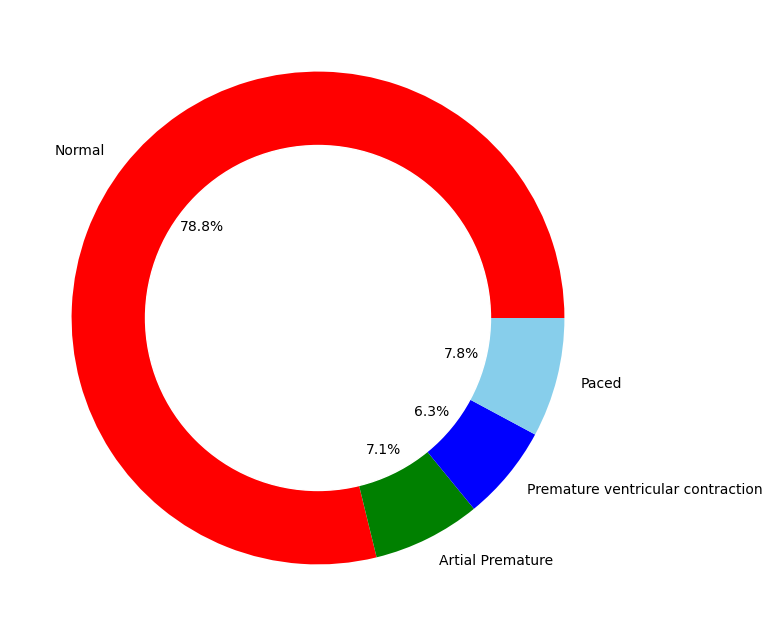

In [17]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [18]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0    18118
1      556
2     1448
3     1608
Name: 187, dtype: int64


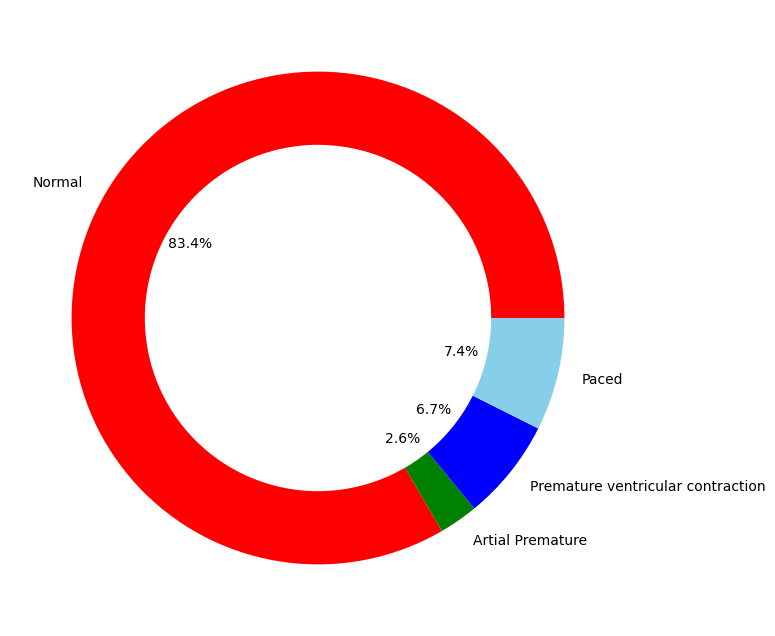

In [19]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Simple ANN

In [ ]:
model_ann = Sequential([
    Dense(256, activation='relu', input_dim=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_ann_5.h5', monitor='val_loss', save_best_only=True)]


history_ann = model_ann.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))
model_ann.load_weights('best_ann_5.h5')
save_model(model_ann, 'ANN_MITBIH_with_GAN_Data', 'keras')

In [ ]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
# Predict test set labels
y_pred_1  = model_ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_1 , axis=1)

print('Accuracy of ANN: ', accuracy_score(y_test, y_pred_ann))

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix ANN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

### CNN

In [20]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_cnn_5.h5', monitor='val_loss', save_best_only=True)]


history_cnn = model_cnn.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))

model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras')

Epoch 1/40
2298/2298 [==============================] - 20s 7ms/step - loss: 0.1194 - accuracy: 0.9673 - val_loss: 0.0793 - val_accuracy: 0.9777
Epoch 2/40
2298/2298 [==============================] - 15s 7ms/step - loss: 0.0685 - accuracy: 0.9800 - val_loss: 0.0643 - val_accuracy: 0.9806
Epoch 3/40
2298/2298 [==============================] - 16s 7ms/step - loss: 0.0553 - accuracy: 0.9838 - val_loss: 0.0634 - val_accuracy: 0.9802
Epoch 4/40
2298/2298 [==============================] - 16s 7ms/step - loss: 0.0455 - accuracy: 0.9860 - val_loss: 0.0491 - val_accuracy: 0.9867
Epoch 5/40
2298/2298 [==============================] - 15s 7ms/step - loss: 0.0402 - accuracy: 0.9875 - val_loss: 0.0625 - val_accuracy: 0.9795
Epoch 6/40
2298/2298 [==============================] - 15s 7ms/step - loss: 0.0341 - accuracy: 0.9895 - val_loss: 0.0638 - val_accuracy: 0.9814
Epoch 7/40
2298/2298 [==============================] - 16s 7ms/step - loss: 0.0304 - accuracy: 0.9904 - val_loss: 0.0456 - val_ac

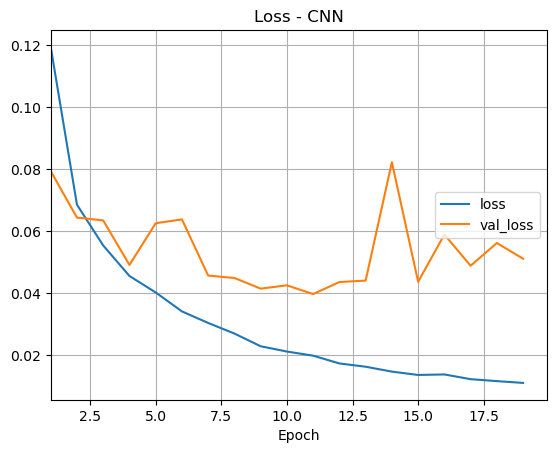

In [21]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

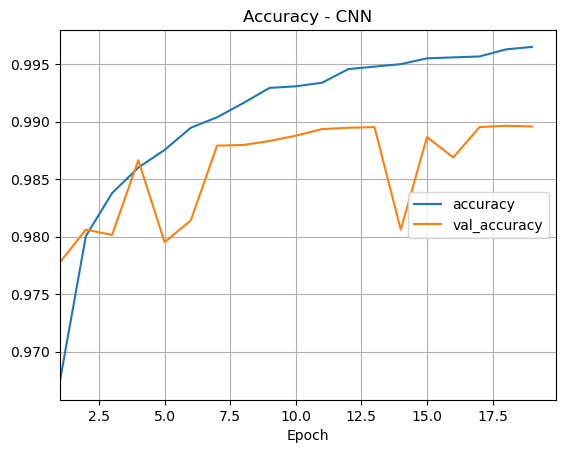

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [23]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_2 , axis=1)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

680/680 [==============================] - 1s 2ms/step
Accuracy of CNN:  0.9923147722043258


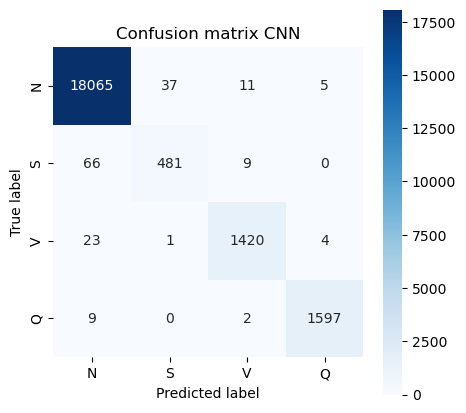

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [25]:
report = classification_report(y_test, y_pred_cnn, target_names=labels, digits=4)
print(report)

                                   precision    recall  f1-score   support

                           Normal     0.9946    0.9971    0.9958     18118
                 Artial Premature     0.9268    0.8651    0.8949       556
Premature ventricular contraction     0.9847    0.9807    0.9827      1448
                            Paced     0.9944    0.9932    0.9938      1608

                         accuracy                         0.9923     21730
                        macro avg     0.9751    0.9590    0.9668     21730
                     weighted avg     0.9922    0.9923    0.9922     21730



In [27]:
# model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras', report)